# Exercise

[*Lesson Page*](https://ds.codeup.com/10-anomaly-detection/4-detecting-timeseries-anomalies/)

**File name:** `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

## Time series + EMA
Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

In [1]:
###############################################################################
### pthon imports                                                           ###
###############################################################################

import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [2]:
###############################################################################
### local imports                                                           ###
###############################################################################

#from env import host, user, password
from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain
import acquire as acq


In [174]:
def ifull(obj):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(obj)

### Get Source Data

***Import and view data***
(Initial view of text file suggests space-deliminited)

In [3]:
df = pd.read_csv('anonymized-curriculum-access.txt', header=None, sep=' ')#.rename(columns={0:'data'})
df.sample(10)

,0,1,2,3,4,5
178275,2019-01-11,09:38:43,spring/fundamentals/repositories,263,26.0,97.105.19.58
249701,2019-04-22,09:28:30,toc,327,29.0,97.105.19.58
365236,2019-10-07,09:27:23,javascript-i/introduction/working-with-data-ty...,502,51.0,97.105.19.58
71095,2018-06-13,14:41:40,javascript-i/functions,197,24.0,97.105.19.61
319544,2019-08-12,15:35:07,9-timeseries/exercises,404,28.0,97.105.19.58
157078,2018-11-16,10:22:54,spring/extra-features/error-pages,256,25.0,107.77.219.67
244316,2019-04-14,09:03:47,toc,211,28.0,173.174.210.2
320527,2019-08-13,16:12:28,study-session-with-ryan,447,33.0,97.105.19.58
122129,2018-09-11,09:05:19,/,225,25.0,97.105.19.58
146805,2018-10-26,23:02:09,appendix/extra-challenges/memory-game,258,25.0,69.166.71.6


***infer column names based on data***

In [4]:
df.rename(columns={0:'ts_date', 1:'ts_time', 2:'path', 3:'unknown_1', 4:'unknown_2', 5: 'ip'}, inplace=True)
df.sample(10)

,ts_date,ts_time,path,unknown_1,unknown_2,ip
170379,2018-12-13,13:55:21,java-iii/jdbc,277,26.0,97.105.19.58
333604,2019-08-27,12:01:45,1-fundamentals/1.1-intro-to-data-science,11,28.0,97.105.19.58
306000,2019-07-23,15:54:23,appendix/git/working-in-teams,415,32.0,97.105.19.58
168313,2018-12-10,16:50:11,spring/fundamentals/views,310,27.0,99.98.36.168
145281,2018-10-24,12:25:47,jquery/essential-methods/attributes-and-css,272,26.0,97.105.19.58
177502,2019-01-08,21:11:52,spring/fundamentals/services,275,26.0,76.204.31.63
124637,2018-09-14,15:00:33,javascript-ii,228,25.0,205.251.148.146
114783,2018-08-27,16:14:57,mysql/database-design,186,24.0,97.105.19.58
323362,2019-08-16,10:08:21,toc,436,33.0,97.105.19.58
167066,2018-12-07,12:06:27,java-iii,53,28.0,97.105.19.58


In [5]:
frame_splain(df, splain=True)

DATAFRAME SHAPE:
(399195, 6)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399195 entries, 0 to 399194
Data columns (total 6 columns):
ts_date      399195 non-null object
ts_time      399195 non-null object
path         399195 non-null object
unknown_1    399195 non-null int64
unknown_2    372441 non-null float64
ip           399195 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 18.3+ MB
None

DATAFRAME DESCRIPTION:
              count        mean         std  min    25%    50%    75%    max
unknown_1  399195.0  268.794667  147.587312  1.0  157.0  288.0  392.0  543.0
unknown_2  372441.0   26.912649    7.846146  1.0   23.0   27.0   31.0   52.0

DATAFRAME HEAD:
      ts_date   ts_time                                 path  unknown_1  \
0  2018-01-26  09:55:03                                    /          1   
1  2018-01-26  09:56:02                              java-ii          1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming   

***Fill missing values in unknown_2***

In [134]:
df.unknown_2 = df.unknown_2.fillna(-1)

In [135]:
df.unknown_2.describe()

count    399195.000000
mean         25.041947
std          10.303056
min          -1.000000
25%          23.000000
50%          26.000000
75%          31.000000
max          52.000000
Name: unknown_2, dtype: float64

***Make datetime index using `date` and `time` values***

Make copy for future use, drop original columns

In [169]:
df['timestamp'] = df.ts_date + ' ' + df.ts_time
df.timestamp=pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')
df['idx'] = df.timestamp
df.set_index('idx', inplace=True)
df.drop(columns=['ts_date','ts_time'], inplace=True)
display(df.sample(10))

,path,unknown_1,unknown_2,ip,timestamp,lvls,path0,path1,path2,path3,path4,path5,path6,path7
idx,,,,,,,,,,,,,,
2018-03-19 13:03:16,java-iii,64,1.0,97.105.19.61,2018-03-19 13:03:16,8,java-iii,,,,,,,
2018-04-24 21:07:07,jquery/personal-site,111,-1.0,70.117.6.133,2018-04-24 21:07:07,8,jquery,personal-site,,,,,,
2019-09-28 12:47:50,html-css/introduction,419,32.0,67.11.157.190,2019-09-28 12:47:50,8,html-css,introduction,,,,,,
2019-04-11 16:22:27,mysql/relationships/sub-queries,64,28.0,97.105.19.58,2019-04-11 16:22:27,8,mysql,relationships,sub-queries,,,,,
2019-08-05 11:18:25,javascript-i/introduction/working-with-data-ty...,435,33.0,97.105.19.58,2019-08-05 11:18:25,8,javascript-i,introduction,working-with-data-types-operators-and-variables,,,,,
2018-06-24 14:13:33,javascript-i/arrays,138,22.0,108.65.244.91,2018-06-24 14:13:33,8,javascript-i,arrays,,,,,,
2018-11-06 15:49:38,toc,267,26.0,97.105.19.58,2018-11-06 15:49:38,8,toc,,,,,,,
2018-03-05 15:30:30,/,133,23.0,97.105.19.61,2018-03-05 15:30:30,8,,,,,,,,
2018-03-14 16:23:28,/,135,23.0,97.105.19.61,2018-03-14 16:23:28,8,,,,,,,,


In [7]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399195 entries, 2018-01-26 09:55:03 to 2019-11-19 10:07:45
Data columns (total 7 columns):
ts_date      399195 non-null object
ts_time      399195 non-null object
path         399195 non-null object
unknown_1    399195 non-null int64
unknown_2    372441 non-null float64
ip           399195 non-null object
timestamp    399195 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 24.4+ MB


None

,unknown_1,unknown_2
count,399195.000000,372441.000000
mean,268.794667,26.912649
std,147.587312,7.846146
min,1.000000,1.000000
25%,157.000000,23.000000
50%,288.000000,27.000000
75%,392.000000,31.000000
max,543.000000,52.000000


***Get values for columns***

In [90]:
df.timestamp.describe()

count                  399195
unique                 384859
top       2019-03-03 22:52:07
freq                       30
first     2018-01-26 09:55:03
last      2019-11-19 10:07:45
Name: timestamp, dtype: object

In [20]:
df.path.value_counts()

/                                                                            20564
javascript-i                                                                  8140
search/search_index.json                                                      7005
toc                                                                           6679
html-css                                                                      6143
java-iii                                                                      6003
spring                                                                        5761
jquery                                                                        5501
java-ii                                                                       5386
mysql                                                                         5103
java-i                                                                        5039
javascript-ii                                                                 5024
mysq

***`path` appears to have folder structure in place, will separate in later step***

In [115]:
df.isna().sum()

ts_date          0
ts_time          0
path             0
unknown_1        0
unknown_2    26754
ip               0
timestamp        0
lvls             0
path0            0
path1            0
path2            0
path3            0
path4            0
path5            0
path6            0
dtype: int64

In [11]:
df.unknown_1.value_counts()

53     8236
64     8008
11     8004
344    5279
1      4266
314    3233
423    2995
323    2846
354    2821
211    2625
418    2598
127    2563
410    2398
277    2367
347    2318
325    2248
363    2237
433    2217
337    2183
186    2180
274    2136
315    2130
416    2103
368    2063
304    2061
272    2008
197    1993
275    1900
264    1898
269    1894
       ... 
137      10
279      10
84       10
141       9
95        9
388       8
107       8
104       8
401       7
115       6
152       5
399       5
71        5
169       5
82        5
62        4
216       4
85        4
246       4
348       3
177       3
89        3
176       3
81        3
97        2
66        1
461       1
163       1
165       1
212       1
Name: unknown_1, Length: 543, dtype: int64

In [136]:
df.unknown_2.value_counts()

 29.0    35969
 24.0    35039
 33.0    34433
 22.0    28875
 23.0    28056
 32.0    26801
 26.0    26760
-1.0     26754
 25.0    25233
 31.0    22665
 28.0    20677
 27.0    20198
 34.0    15519
 51.0    10835
 14.0     9069
 1.0      8877
 21.0     7181
 17.0     3792
 52.0     2896
 13.0     2610
 8.0      1671
 18.0     1603
 19.0     1142
 16.0      740
 15.0      691
 7.0       461
 12.0      270
 11.0      204
 2.0        93
 6.0        72
 9.0         5
 4.0         4
Name: unknown_2, dtype: int64

***`unknown_2` appears to be some kind of index value***

In [14]:
df.ip.value_counts()

97.105.19.58       227220
97.105.19.61        61662
192.171.117.210      8127
70.122.40.62         1338
66.69.108.117        1199
173.174.211.206      1019
108.65.244.91        1007
170.248.173.245       997
67.11.157.190         972
66.69.62.219          934
70.118.8.243          876
72.181.104.64         865
170.248.173.247       828
216.1.153.162         823
67.11.215.97          818
76.185.131.226        793
173.173.113.51        779
67.11.239.2           777
99.61.24.168          765
67.10.174.56          739
72.181.98.75          681
45.23.250.16          663
67.10.161.55          651
136.50.18.71          631
76.204.31.63          618
4.16.216.161          610
72.181.110.80         607
170.248.173.246       590
67.10.166.10          578
70.121.163.5          577
                    ...  
72.177.198.47           1
107.77.220.6            1
107.77.221.80           1
174.207.12.44           1
67.11.82.179            1
107.77.100.91           1
99.203.26.111           1
173.239.232.

In [170]:
df['slash']=df.path.str.count('/')
max_slash = df.slash.max()
print('max_slash:', max_slash)
df['newslashes'] = max_slash - df.slash
df['slashes'] = df.newslashes.apply(lambda x: x * '/')
df['pathslash'] = df.path + df.slashes
df['repath']=df.pathslash.str.split('/')
for lvl in range(max_slash+1):
    col_name = 'path' + str(lvl)
    df[col_name] = df.pathslash.apply(lambda x: x.split('/')[lvl])
    
df.drop(columns=['slash','newslashes','slashes','pathslash','repath'], inplace=True)
display(df.sample(10))

max_slash: 7


,path,unknown_1,unknown_2,ip,timestamp,lvls,path0,path1,path2,path3,path4,path5,path6,path7
idx,,,,,,,,,,,,,,
2019-05-16 09:03:13,Intro_to_Regression_Module,351,-1.0,97.105.19.58,2019-05-16 09:03:13,8,Intro_to_Regression_Module,,,,,,,
2018-01-30 10:21:54,javascript-i,7,22.0,97.105.19.61,2018-01-30 10:21:54,8,javascript-i,,,,,,,
2018-03-14 12:14:38,java-ii/interfaces-and-abstract-classes,138,22.0,97.105.19.61,2018-03-14 12:14:38,8,java-ii,interfaces-and-abstract-classes,,,,,,
2018-07-31 11:56:10,java-i/methods,192,24.0,97.105.19.58,2018-07-31 11:56:10,8,java-i,methods,,,,,,
2018-08-02 08:22:51,html-css/css-ii/bootstrap-introduction,227,25.0,97.105.19.58,2018-08-02 08:22:51,8,html-css,css-ii,bootstrap-introduction,,,,,
2018-07-10 11:04:29,jquery/personal-site,201,24.0,97.105.19.61,2018-07-10 11:04:29,8,jquery,personal-site,,,,,,
2018-10-19 09:10:48,java-iii/servlets,227,25.0,97.105.19.58,2018-10-19 09:10:48,8,java-iii,servlets,,,,,,
2019-03-18 13:34:35,javascript-ii/map-filter-reduce,345,29.0,97.105.19.58,2019-03-18 13:34:35,8,javascript-ii,map-filter-reduce,,,,,,
2019-06-12 15:43:38,javascript-i/introduction/variables,413,32.0,97.105.19.58,2019-06-12 15:43:38,8,javascript-i,introduction,variables,,,,,


In [88]:
df.path0.value_counts()

javascript-i                  55152
html-css                      40885
mysql                         39823
jquery                        29903
spring                        28620
java-iii                      25938
java-ii                       23882
                              20564
javascript-ii                 20343
java-i                        19283
appendix                      13760
content                        7805
examples                       7353
search                         7007
slides                         6872
toc                            6679
1-fundamentals                 3120
4-python                       2798
6-regression                   2588
3-sql                          2348
mkdocs                         1909
5-stats                        1855
7-classification               1536
8-clustering                   1163
index.html                     1155
2-storytelling                  944
web-design                      826
9-timeseries                

In [131]:
df.path3.value_counts()

                                      386643
authentication                          1964
flexbox-fundamentals                    1002
gitbook                                  862
css-grid-fundamentals                    786
flexbox-in-practice                      722
images                                   711
intellij-tomcat-configuration            708
css-grid-in-practice                     685
css-grid-intro                           604
authorization                            383
devtools-configuration                   362
seeder                                   255
security-use-cases                       211
pagination                               182
array-splice                             172
hoisting                                 151
application-structure.html               150
environment.html                         117
hello-world-and-other-strings.html        74
db-migrations.html                        66
this                                      64
resource-c

***Theory to test: Unknown 1 is user, Unknown 2 is cohort***

Check by grouping together and reviewing results

In [137]:
dfunk12 = df.groupby(by=['unknown_1', 'unknown_2'], as_index=False).timestamp.agg(['count', 'min', 'max'])
dfunk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 516 entries, (1, 8.0) to (543, 33.0)
Data columns (total 3 columns):
count    516 non-null int64
min      516 non-null datetime64[ns]
max      516 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 18.2 KB


In [166]:
dfunk12

count                 min                 max
unknown_1 unknown_2                                               
1         8.0         1617 2018-01-26 09:55:03 2018-12-05 08:01:42
          28.0        2649 2018-12-08 18:25:15 2019-11-19 08:38:17
2         22.0        1541 2018-01-26 09:56:24 2018-05-10 18:25:38
3         22.0        1562 2018-01-26 09:56:46 2019-04-06 21:32:32
4         22.0         692 2018-01-26 09:58:26 2018-03-27 14:28:18
5         22.0        1701 2018-01-26 09:59:22 2018-07-19 14:08:20
6         22.0        1408 2018-01-26 10:00:02 2019-03-18 22:13:39
7         22.0        1803 2018-01-26 10:02:02 2019-06-27 14:18:37
8         22.0         483 2018-01-26 10:02:21 2018-03-14 15:46:06
9         22.0         585 2018-01-26 10:02:42 2018-05-11 11:28:51
10        21.0         750 2018-01-26 10:08:22 2019-05-23 12:39:47
11        1.0         2735 2018-01-26 10:14:47 2018-12-06 11:14:11
          28.0        5269 2018-12-07 09:05:02 2019-11-19 10:01:25
12        22.0         729 2018-01-26 10:33:18 2018-11-19 11:02:46
13        22.0          79 2018-01-26 10:33:25 2018-05-02 17:15:29
14        22.0         596 2018-01-26 10:35:08 2018-10-10 17:38:59
15        21.0         296 2018-01-26 10:35:28 2019-11-12 19:27:54
16        21.0         193 2018-01-26 10:35:29 2019-05-23 16:21:57
17        21.0         175 2018-01-26 10:35:35 2018-02-18 12:42:12
18        22.0        1455 2018-01-26 10:39:50 2019-10-22 15:44:16
19        22.0        1518 2018-01-26 10:41:21 2019-10-12 16:52:58
20        22.0         624 2018-01-26 10:44:06 2019-10-08 11:13:40
21        16.0         107 2018-01-26 10:59:02 2018-07-18 14:13:42
22        21.0         199 2018-01-26 11:11:52 2018-02-27 23:23:58
23        22.0         969 2018-01-26 11:14:07 2018-03-09 09:02:49
24        21.0          26 2018-01-26 11:24:17 2018-02-07 11:07:31
25        22.0         451 2018-01-26 11:36:00 2018-03-05 13:21:32
          23.0        1358 2018-03-05 14:22:48 2019-07-15 13:45:06
26        18.0         474 2018-01-26 11:36:27 2019-10-11 23:02:05
27        21.0         482 2018-01-26 11:40:33 2018-07-18 15:32:05
...                    ...                 ...                 ...
515       33.0         233 2019-11-04 09:53:24 2019-11-19 09:54:29
516       52.0          62 2019-11-04 16:03:34 2019-11-19 10:01:50
517       52.0          51 2019-11-04 16:03:35 2019-11-19 08:22:25
518       52.0          69 2019-11-04 16:03:35 2019-11-19 09:01:36
519       52.0         104 2019-11-04 16:03:35 2019-11-19 08:58:54
520       52.0          88 2019-11-04 16:03:35 2019-11-19 09:37:54
521       52.0         189 2019-11-04 16:03:35 2019-11-19 08:57:33
522       52.0         133 2019-11-04 16:03:36 2019-11-19 10:00:33
523       52.0          50 2019-11-04 16:03:36 2019-11-18 16:01:13
524       52.0         328 2019-11-04 16:03:37 2019-11-19 08:25:36
525       52.0         105 2019-11-04 16:03:37 2019-11-18 16:11:09
526       52.0         111 2019-11-04 16:03:38 2019-11-19 10:00:40
527       52.0          85 2019-11-04 16:03:39 2019-11-19 08:03:02
528       52.0         120 2019-11-04 16:03:42 2019-11-19 10:04:08
529       52.0          36 2019-11-04 16:03:42 2019-11-08 10:54:44
530       52.0         109 2019-11-04 16:03:43 2019-11-19 09:13:35
531       52.0         307 2019-11-04 16:03:45 2019-11-19 08:59:44
532       52.0         100 2019-11-04 16:03:45 2019-11-19 10:02:00
533       52.0         103 2019-11-04 16:03:49 2019-11-19 08:47:42
534       52.0          71 2019-11-04 16:03:50 2019-11-18 10:48:19
535       52.0          57 2019-11-04 16:03:54 2019-11-19 10:02:24
536       52.0         118 2019-11-04 16:04:21 2019-11-19 09:13:46
537       52.0          89 2019-11-04 16:05:04 2019-11-18 21:40:26
538       52.0         105 2019-11-04 16:06:07 2019-11-19 08:54:24
539       28.0          27 2019-11-05 11:04:37 2019-11-12 12:37:05
          52.0           5 2019-11-04 16:19:26 2019-11-04 16:54:45
540       52.0         158 2019-11-05 14:20:36 2019-11-19 10:00:29
5

In [139]:
dfunk12.index

MultiIndex(levels=[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

In [138]:
dfunk21 = df.groupby(by=['unknown_2', 'unknown_1']).timestamp.agg(['count', 'min', 'max'])
dfunk.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 516 entries, (1, 8.0) to (543, 33.0)
Data columns (total 3 columns):
count    516 non-null int64
min      516 non-null datetime64[ns]
max      516 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 18.2 KB


In [143]:
dfunk21

count                 min                 max
unknown_2 unknown_1                                               
-1.0      48          1470 2018-01-26 16:46:16 2019-11-14 20:04:40
          54           146 2018-01-28 23:42:55 2019-03-26 17:10:32
          58           462 2018-01-29 11:02:27 2019-05-03 13:00:32
          59            42 2018-01-29 11:24:17 2018-06-28 15:40:45
          61           816 2018-01-29 13:00:48 2018-09-17 11:37:34
          62             4 2018-01-29 13:08:55 2018-01-29 13:09:14
          63            22 2018-01-29 13:26:25 2019-05-02 15:18:13
          73            84 2018-01-30 19:42:02 2019-11-11 21:27:58
          74            80 2018-01-31 07:40:38 2018-02-27 17:59:14
          78            53 2018-01-31 20:13:40 2018-07-18 13:43:12
          79           191 2018-01-31 20:31:24 2019-11-01 13:10:23
          86           177 2018-02-04 17:02:16 2018-05-15 14:28:57
          88           223 2018-02-05 21:40:45 2019-08-17 12:18:42
          89             3 2018-02-06 09:07:47 2018-02-06 09:08:02
          100           59 2018-02-13 10:07:03 2018-02-23 19:10:21
          103           42 2018-02-16 16:38:04 2018-12-05 13:51:29
          111          753 2018-02-28 18:12:27 2019-01-04 10:43:38
          137           10 2018-03-06 13:58:34 2018-03-07 09:33:18
          166           77 2018-04-02 23:49:44 2019-05-22 21:06:27
          176            3 2018-05-04 13:44:51 2018-05-04 13:45:00
          213           13 2018-06-20 09:07:42 2018-06-20 09:14:35
          247           66 2018-08-27 01:58:00 2018-08-27 01:59:21
          317           73 2018-12-18 12:37:05 2018-12-19 14:55:00
          349         1593 2019-02-04 16:22:20 2019-11-19 08:45:05
          350           87 2019-02-04 16:22:36 2019-02-21 11:32:30
          351          789 2019-02-04 16:23:34 2019-11-12 08:28:19
          352          767 2019-02-04 16:36:36 2019-07-26 15:17:31
          353         1370 2019-02-04 16:43:35 2019-10-18 21:29:11
          354         2821 2019-02-04 16:44:49 2019-10-12 07:44:44
          355         1436 2019-02-04 16:46:24 2019-06-08 07:44:14
...                    ...                 ...                 ...
 51.0     510          623 2019-09-16 16:02:35 2019-11-19 08:47:19
          511          572 2019-09-16 16:02:42 2019-11-18 11:48:46
          512          481 2019-09-17 11:56:57 2019-11-18 12:21:20
 52.0     516           62 2019-11-04 16:03:34 2019-11-19 10:01:50
          517           51 2019-11-04 16:03:35 2019-11-19 08:22:25
          518           69 2019-11-04 16:03:35 2019-11-19 09:01:36
          519          104 2019-11-04 16:03:35 2019-11-19 08:58:54
          520           88 2019-11-04 16:03:35 2019-11-19 09:37:54
          521          189 2019-11-04 16:03:35 2019-11-19 08:57:33
          522          133 2019-11-04 16:03:36 2019-11-19 10:00:33
          523           50 2019-11-04 16:03:36 2019-11-18 16:01:13
          524          328 2019-11-04 16:03:37 2019-11-19 08:25:36
          525          105 2019-11-04 16:03:37 2019-11-18 16:11:09
          526          111 2019-11-04 16:03:38 2019-11-19 10:00:40
          527           85 2019-11-04 16:03:39 2019-11-19 08:03:02
          528          120 2019-11-04 16:03:42 2019-11-19 10:04:08
          529           36 2019-11-04 16:03:42 2019-11-08 10:54:44
          530          109 2019-11-04 16:03:43 2019-11-19 09:13:35
          531          307 2019-11-04 16:03:45 2019-11-19 08:59:44
          532          100 2019-11-04 16:03:45 2019-11-19 10:02:00
          533          103 2019-11-04 16:03:49 2019-11-19 08:47:42
          534           71 2019-11-04 16:03:50 2019-11-18 10:48:19
          535           57 2019-11-04 16:03:54 2019-11-19 10:02:24
          536          118 2019-11-04 16:04:21 2019-11-19 09:13:46
          537           89 2019-11-04 16:05:04 2019-11-18 21:40:26
          538          105 2019-11-04 16:06:07 2019-11-19 08:54:24
          539            5 2019-11-04 16:19:26 2019-11-04 16:54:45
 

In [158]:
dfunk21.index

MultiIndex(levels=[[-1.0, 1.0, 2.0, 4.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 51.0, 52.0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [141]:
dfunk12.groupby(by='unknown_2').agg(['count', 'min', 'max'])

count              min                                          \
          count  min   max count                 min                 max   
unknown_2                                                                  
-1.0         49    3  2821    49 2018-01-26 16:46:16 2019-06-12 12:48:26   
 1.0         18    1  3767    18 2018-01-26 10:14:47 2019-05-01 14:08:54   
 2.0          3   11    68     3 2018-03-19 03:09:52 2019-03-22 23:26:26   
 4.0          1    4     4     1 2018-02-04 11:21:38 2018-02-04 11:21:38   
 6.0          2   13    59     2 2018-10-16 03:56:59 2019-05-12 21:38:15   
 7.0          6    3   311     6 2018-01-31 19:09:55 2019-10-11 12:11:24   
 8.0          4   13  1617     4 2018-01-26 09:55:03 2018-04-25 23:38:22   
 9.0          1    5     5     1 2018-03-22 19:01:49 2018-03-22 19:01:49   
 11.0         5    3   155     5 2018-05-07 20:12:30 2019-08-10 07:42:10   
 12.0         4   10   224     4 2018-02-15 19:51:45 2018-08-08 13:15:17   
 13.0        10    1  1351    10 2018-01-26 21:42:26 2019-01-08 17:37:20   
 14.0        10    4  7915    10 2018-01-28 18:48:19 2018-08-23 23:24:13   
 15.0         5    8   530     5 2018-01-30 17:40:15 2019-05-29 15:43:37   
 16.0         8    1   510     8 2018-01-26 10:59:02 2019-01-17 11:11:09   
 17.0        12   13  2529    12 2018-02-15 20:26:49 2019-08-16 14:37:35   
 18.0        13    3   474    13 2018-01-26 11:36:27 2018-07-09 15:08:18   
 19.0        16    1   303    16 2018-01-26 12:37:53 2019-08-24 21:50:52   
 21.0        28    6  1132    28 2018-01-26 10:08:22 2019-04-17 15:05:17   
 22.0        35   40  1803    35 2018-01-26 09:56:24 2019-07-22 09:46:54   
 23.0        33   14  2563    33 2018-03-05 14:22:48 2019-01-09 21:25:21   
 24.0        33   68  2180    33 2018-05-29 14:42:38 2018-09-27 13:57:44   
 25.0        26  454  1743    26 2018-07-23 13:51:26 2018-10-08 14:08:13   
 26.0        20  303  2367    20 2018-09-17 14:12:28 2018-12-05 12:33:40   
 27.0        28    7  2061    28 2018-11-05 14:03:58 2019-04-24 15:39:45   
 28.0        19    1  5269    19 2018-12-06 14:15:29 2019-11-05 11:04:37   
 29.0        25   18  5279    25 2019-01-22 15:09:54 2019-01-23 14:29:52   
 31.0        28    8  1798    28 2019-03-18 16:01:40 2019-08-13 10:30:35   
 32.0        20  163  2995    20 2019-05-29 09:48:59 2019-05-29 11:57:08   
 33.0        29   44  2217    29 2019-07-15 15:39:34 2019-11-12 15:05:23   
 34.0        22   17  1343    22 2019-08-20 09:39:58 2019-08-30 12:01:29   
 51.0        25  146   773    25 2019-09-16 15:45:32 2019-09-17 11:56:57   
 52.0        27    5   328    27 2019-11-04 16:03:34 2019-11-09 22:21:20   

            max                                          
          count                 min                 max  
unknown_2                                                
-1.0         49 2018-01-29 13:09:14 2019-11-19 08:45:05  
 1.0         18 2018-02-16 16:42:05 2019-10-22 14:26:31  
 2.0          3 2018-04-15 22:08:53 2019-07-31 16:01:25  
 4.0          1 2018-02-04 11:24:56 2018-02-04 11:24:56  
 6.0          2 2019-01-06 07:59:49 2019-05-12 21:40:52  
 7.0          6 2018-01-31 19:10:40 2019-11-17 19:37:42  
 8.0          4 2018-03-01 21:07:44 2018-12-05 08:01:42  
 9.0          1 2018-03-22 19:02:52 2018-03-22 19:02:52  
 11.0         5 2018-05-07 20:12:49 2019-08-10 20:19:03  
 12.0         4 2018-03-28 20:29:26 2019-08-26 18:05:17  
 13.0        10 2018-01-29 15:48:48 2019-11-04 13:28:44  
 14.0        10 2018-02-03 12:24:30 2019-11-18 15:28:31  
 15.0         5 2018-02-19 22:25:11 2019-08-01 15:51:43  
 16.0         8 2018-02-11 20:24:17 2019-03-04 10:48:48  
 17.0        12 2018-06-18 17:31:35 2019-11-19 09:55:55  
 18.0        13 2018-02-03 12:04:45 2019-11-11 08:15:35  
 19.0        16 2018-01-30 15:01:40 2019-10-13 12:19:22  
 21.0        28 2018-02-05 09:08:24 2019-11-15 14:25:34  
 22.0        35 2018-02-12 18:04:04 2019-10-22 15:44:16  
 23.0        33 2018-03-15 13:57:57 2019-11-10 21:41:45  
 24.0        33

In [171]:
dfunk21.groupby(by='unknown_1').agg(['count', 'min', 'max'])

count               min                                          \
          count   min   max count                 min                 max   
unknown_1                                                                   
1             2  1617  2649     2 2018-01-26 09:55:03 2018-12-08 18:25:15   
2             1  1541  1541     1 2018-01-26 09:56:24 2018-01-26 09:56:24   
3             1  1562  1562     1 2018-01-26 09:56:46 2018-01-26 09:56:46   
4             1   692   692     1 2018-01-26 09:58:26 2018-01-26 09:58:26   
5             1  1701  1701     1 2018-01-26 09:59:22 2018-01-26 09:59:22   
6             1  1408  1408     1 2018-01-26 10:00:02 2018-01-26 10:00:02   
7             1  1803  1803     1 2018-01-26 10:02:02 2018-01-26 10:02:02   
8             1   483   483     1 2018-01-26 10:02:21 2018-01-26 10:02:21   
9             1   585   585     1 2018-01-26 10:02:42 2018-01-26 10:02:42   
10            1   750   750     1 2018-01-26 10:08:22 2018-01-26 10:08:22   
11            2  2735  5269     2 2018-01-26 10:14:47 2018-12-07 09:05:02   
12            1   729   729     1 2018-01-26 10:33:18 2018-01-26 10:33:18   
13            1    79    79     1 2018-01-26 10:33:25 2018-01-26 10:33:25   
14            1   596   596     1 2018-01-26 10:35:08 2018-01-26 10:35:08   
15            1   296   296     1 2018-01-26 10:35:28 2018-01-26 10:35:28   
16            1   193   193     1 2018-01-26 10:35:29 2018-01-26 10:35:29   
17            1   175   175     1 2018-01-26 10:35:35 2018-01-26 10:35:35   
18            1  1455  1455     1 2018-01-26 10:39:50 2018-01-26 10:39:50   
19            1  1518  1518     1 2018-01-26 10:41:21 2018-01-26 10:41:21   
20            1   624   624     1 2018-01-26 10:44:06 2018-01-26 10:44:06   
21            1   107   107     1 2018-01-26 10:59:02 2018-01-26 10:59:02   
22            1   199   199     1 2018-01-26 11:11:52 2018-01-26 11:11:52   
23            1   969   969     1 2018-01-26 11:14:07 2018-01-26 11:14:07   
24            1    26    26     1 2018-01-26 11:24:17 2018-01-26 11:24:17   
25            2   451  1358     2 2018-01-26 11:36:00 2018-03-05 14:22:48   
26            1   474   474     1 2018-01-26 11:36:27 2018-01-26 11:36:27   
27            1   482   482     1 2018-01-26 11:40:33 2018-01-26 11:40:33   
28            1   282   282     1 2018-01-26 11:40:52 2018-01-26 11:40:52   
29            1   894   894     1 2018-01-26 11:46:04 2018-01-26 11:46:04   
30            1  1397  1397     1 2018-01-26 11:46:42 2018-01-26 11:46:42   
...         ...   ...   ...   ...                 ...                 ...   
514           1    96    96     1 2019-10-16 11:33:39 2019-10-16 11:33:39   
515           1   233   233     1 2019-11-04 09:53:24 2019-11-04 09:53:24   
516           1    62    62     1 2019-11-04 16:03:34 2019-11-04 16:03:34   
517           1    51    51     1 2019-11-04 16:03:35 2019-11-04 16:03:35   
518           1    69    69     1 2019-11-04 16:03:35 2019-11-04 16:03:35   
519           1   104   104     1 2019-11-04 16:03:35 2019-11-04 16:03:35   
520           1    88    88     1 2019-11-04 16:03:35 2019-11-04 16:03:35   
521           1   189   189     1 2019-11-04 16:03:35 2019-11-04 16:03:35   
522           1   133   133     1 2019-11-04 16:03:36 2019-11-04 16:03:36   
523           1    50    50     1 2019-11-04 16:03:36 2019-11-04 16:03:36   
524           1   328   328     1 2019-11-04 16:03:37 2019-11-04 16:03:37   
525           1   105   105     1 2019-11-04 16:03:37 2019-11-04 16:03:37   
526           1   111   111     1 2019-11-04 16:03:38 2019-11-04 16:03:38   
527           1    85    85     1 2019-11-04 16:03:39 2019-11-04 16:03:39   
528           1   120   120     1 2019-11-04 16:03:42 2019-11-04 16:03:42   
529           1    36    36     1 2019-11-04 16:03:42 2019-11-04 16:03:42   
530           1   109   109     1 2019-11-04 16:03:43 2019-11-04 16:03:43   
531           1   307   307     1 2019-11-04 16:03:45 2019-11-04 16:03:45   
532   

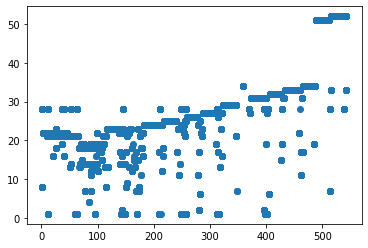

In [133]:
plt.scatter(x=df.unknown_1, y=df.unknown_2)

***Bayes is `unknown_2` 34. Counts don't always match cohorts, though, so going with `group`. `Unknown_1` is definitely user. Rename columns.***

In [172]:
df.rename(columns={'unknown_1': 'user','unknown_2':'group'}, inplace=True)
frame_splain(df,splain=True)

DATAFRAME SHAPE:
(399195, 14)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399195 entries, 2018-01-26 09:55:03 to 2019-11-19 10:07:45
Data columns (total 14 columns):
path         399195 non-null object
user         399195 non-null int64
group        399195 non-null float64
ip           399195 non-null object
timestamp    399195 non-null datetime64[ns]
lvls         399195 non-null int64
path0        399195 non-null object
path1        399195 non-null object
path2        399195 non-null object
path3        399195 non-null object
path4        399195 non-null object
path5        399195 non-null object
path6        399195 non-null object
path7        399195 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 45.7+ MB
None

DATAFRAME DESCRIPTION:
          count        mean         std  min    25%    50%    75%    max
user   399195.0  268.794667  147.587312  1.0  157.0  288.0  392.0  543.0
group  399195.0   25.041947   10.303056

In [176]:
df[df.group==34]

,path,user,group,ip,timestamp,lvls,path0,path1,path2,path3,path4,path5,path6,path7
idx,,,,,,,,,,,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58,2019-08-20 09:39:58,8,,,,,,,,
2019-08-20 09:39:59,/,467,34.0,97.105.19.58,2019-08-20 09:39:59,8,,,,,,,,
2019-08-20 09:39:59,/,468,34.0,97.105.19.58,2019-08-20 09:39:59,8,,,,,,,,
2019-08-20 09:40:02,/,469,34.0,97.105.19.58,2019-08-20 09:40:02,8,,,,,,,,
2019-08-20 09:40:08,/,470,34.0,97.105.19.58,2019-08-20 09:40:08,8,,,,,,,,
2019-08-20 09:40:15,/,471,34.0,97.105.19.58,2019-08-20 09:40:15,8,,,,,,,,
2019-08-20 09:40:15,/,472,34.0,97.105.19.58,2019-08-20 09:40:15,8,,,,,,,,
2019-08-20 09:40:17,/,473,34.0,97.105.19.58,2019-08-20 09:40:17,8,,,,,,,,
2019-08-20 09:40:18,/,474,34.0,97.105.19.58,2019-08-20 09:40:18,8,,,,,,,,


In [163]:
dfpathuse = df.groupby(by=['path0','unknown_2','unknown_1']).agg(['count','min','max'])
display dfpathuse.info

ts_date                         ts_time  \
                                 count         min         max   count   
path0      unknown_2 unknown_1                                           
           -1.0      48            101  2018-01-26  2019-11-13     101   
                     54             16  2018-01-28  2019-03-26      16   
                     58             42  2018-01-29  2019-05-02      42   
                     59              1  2018-06-28  2018-06-28       1   
                     61              5  2018-04-23  2018-09-07       5   
                     62              1  2018-01-29  2018-01-29       1   
                     63              6  2018-01-29  2019-05-02       6   
                     73              7  2018-01-30  2019-11-11       7   
                     74             11  2018-01-31  2018-02-27      11   
                     78             15  2018-01-31  2018-07-18      15   
                     79             10  2018-01-31  2019-10-31      10   
                     86             16  2018-02-04  2018-05-15      16   
                     88             32  2018-02-17  2019-08-17      32   
                     89              1  2018-02-06  2018-02-06       1   
                     100             3  2018-02-13  2018-02-23       3   
                     103             4  2018-02-16  2018-12-05       4   
                     111            52  2018-02-28  2019-01-04      52   
                     137             2  2018-03-06  2018-03-06       2   
                     166            10  2018-04-02  2019-05-22      10   
                     176             1  2018-05-04  2018-05-04       1   
                     213             1  2018-06-20  2018-06-20       1   
                     247             1  2018-08-27  2018-08-27       1   
                     349           211  2019-02-04  2019-11-19     211   
                     350             9  2019-02-04  2019-02-21       9   
                     351            32  2019-02-04  2019-11-12      32   
                     352            43  2019-02-04  2019-07-26      43   
                     353           172  2019-02-04  2019-10-18     172   
                     354           292  2019-02-04  2019-10-12     292   
                     355           144  2019-02-04  2019-06-08     144   
                     356             3  2019-02-04  2019-02-06       3   
...                                ...         ...         ...     ...   
web-design  33.0     440             8  2019-09-03  2019-11-15       8   
                     441             8  2019-08-28  2019-08-28       8   
                     442             1  2019-07-20  2019-07-20       1   
                     443            10  2019-08-28  2019-09-04      10   
                     444             7  2019-08-28  2019-08-28       7   
                     445            13  2019-08-28  2019-09-04      13   
                     446             2  2019-08-28  2019-08-28       2   
                     448            10  2019-08-28  2019-09-04      10   
                     449            10  2019-08-28  2019-08-28      10   
                     450             7  2019-08-05  2019-11-15       7   
                     451            10  2019-08-28  2019-09-03      10   
                     452            14  2019-08-28  2019-09-05      14   
                     453            12  2019-08-28  2019-09-08      12   
                     455             3  2019-08-29  2019-10-31       3   
                     456             9  2019-08-28  2019-08-28       9   
                     457            16  2019-08-28  2019-11-15      16   
                     458             3  2019-08-28  2019-08-28       3   
                     460             2  2019-08-28  2019-08-28       2   
            51.0     488             6  2019-11-01  2019-11-01       6   
                     489             9  2019-10-10  2019-11-01       9   
                     490           

## Bonus:

Can you label students who are viewing both the web dev and data science curriculum? 
Can you label students by the program they are in? Can you label users by student vs. staff? 
What are Zach, Maggie, David, and Ryan's ids?